## Setup

In [1]:
%cd /home/lbonati@iit.local/work/encoderops/
%env LMDB_PATH=/tmp/lmdb/ 
#/home/lbonati@iit.local/work/encoderops/DESRES/lmdb/
%env DATA_PATH=/home/lbonati@iit.local/work/encoderops/DESRES/

/home/lbonati@iit.local/work/encoderops
env: LMDB_PATH=/tmp/lmdb/
env: DATA_PATH=/home/lbonati@iit.local/work/encoderops/DESRES/


In [16]:
import treescope
import pandas as pd
import torch
from dotenv import load_dotenv
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
from src.configs import ModelArgs # noqa
from torch.utils.data import RandomSampler
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
from src.data import mdtraj_load
import numpy as np
import os
from analysis.descriptors import compute_descriptors
import wandb
load_dotenv()

#treescope.basic_interactive_setup()

protein_id = "2JOF"
traj_id = 0
api = wandb.Api()

for run in api.runs(f"csml/encoderops-{protein_id}"):
    updated: bool = False
    if run.state == "finished":
        data_path = Path(f"DESRES/checkpoints/encoderops-{protein_id}/{run.id}")
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
        model_args = asdict(model.model_args)
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

def deterministic_sampler(dataset, subsample:float, seed: int, verbose: bool = True):
    generator = torch.Generator()
    generator.manual_seed(seed)
    num_samples = int(len(dataset)*subsample)
    if verbose:
        logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
    sampler = RandomSampler(dataset, num_samples=num_samples, generator=generator)
    return sampler


def load_run(run_id: str, protein_id: str, traj_id:int = 0, epoch: int | None = None, progress: bool = True, subsample: float | None = None):
    reg=1e-4
    rng_seed = 42
    batch_size = 1024
    data_path = Path(f"DESRES/checkpoints/encoderops-{protein_id}/{run_id}")
    if epoch is None:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
    else:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
    embeddings = {"t": [], "lag": []}
    model = model.eval()
    print(len(dataset))
    if subsample is not None:
        if subsample > 1: 
            # striding with subsample
            logger.info(f"Subsampling every {subsample} samples ({int(len(dataset)/subsample):d})")
            sample_idxs = [idx for idx in range(0, len(dataset), subsample)]
            dataset = [dataset[idx] for idx in sample_idxs]
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        else:
            # random sampling
            num_samples = int(len(dataset)*subsample)
            logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
            sample_idxs = [idx for idx in deterministic_sampler(dataset, subsample, rng_seed, verbose=False)]
            sampler = deterministic_sampler(dataset, subsample, rng_seed)
            dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        dataloader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False
        )
        sample_idxs = None

    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t = model._setup_graph_data(batch)
            x_lag = model._setup_graph_data(batch, key="item_lag")
            # forward
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    logger.info(f"model mean {model.f_mean}\nstat mean {phi_t.mean(dim=0)}\n diff {model.f_mean.to('cpu') - phi_t.mean(dim=0)}")
    cov_X = model.cov.to('cpu')
    cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
    cov_XY = model.cross_cov.to('cpu')
    G = torch.linalg.solve(cov_X, cov_XY)
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    sort_perm = torch.argsort(l.abs(), descending=True)
    l = l[sort_perm]
    Q = Q[:, sort_perm]
    r_fun = phi_t.to(dtype=Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun,
        "sample_idxs": sample_idxs
    }
    return model, results

def descriptors(protein_id: str, sample_idxs: list[int] | None, descriptors=['dihedrals'], traj_id:int = 0, ):
    protein_path = Path(os.environ["DATA_PATH"]) / f"DESRES-Trajectory_{protein_id}-{traj_id}-protein/{protein_id}-{traj_id}-protein"
    trajectory_files = sorted([str(traj) for traj in protein_path.glob("*.dcd")])
    top = next(protein_path.glob("*.pdb")).__str__()
    traj = mdtraj_load(trajectory_files, top, 1)
    if sample_idxs:
        traj = traj[sample_idxs]
    descriptors_df, feats_info = compute_descriptors(traj, descriptors)
    return traj, descriptors_df, feats_info

2025-05-15 15:43:00.523 | INFO     | __main__:<module>:42 - Run y7exsjsl was already up to date
2025-05-15 15:43:00.922 | INFO     | __main__:<module>:42 - Run o39dkz40 was already up to date
2025-05-15 15:43:01.335 | INFO     | __main__:<module>:42 - Run o778zvrh was already up to date
2025-05-15 15:43:01.721 | INFO     | __main__:<module>:42 - Run 8szjhk4u was already up to date


## PLOTS

In [139]:
df = pd.read_csv('analysis/trpcage/COLVAR_WITH_TICA.csv',index_col=0)

subsample = 10
df['time'] = df.index*subsample*0.2/1000

df_r = df.rolling(5,min_periods=1).mean()

df_r

,radius_of_gyration,num_hbonds,rmsd,Q,TICA-1,TICA-2,time
0,0.726296,4.000000,0.157715,0.966667,1.028881,-0.001077,0.000
1,0.723676,5.500000,0.195854,0.945833,1.036026,-0.001939,0.001
2,0.721724,5.666667,0.204149,0.925000,1.048279,-0.001846,0.002
3,0.720814,5.750000,0.204419,0.931250,1.047570,-0.002454,0.003
4,0.723584,5.800000,0.210071,0.936667,1.045181,-0.002590,0.004
...,...,...,...,...,...,...,...
104295,0.724539,7.000000,0.221722,0.935000,1.023614,-0.002341,208.586
104296,0.722564,6.800000,0.211181,0.938333,1.017045,-0.002110,208.588
104297,0.724037,6.600000,0.207881,0.940000,1.015088,-0.003000,208.590
104298,0.723993,7.000000,0.215652,0.936667,0.996135,-0.003392,208.592


In [140]:
# Normalize min-max
def normalize_minmax(y, mask = None):
    if mask is not None:
        y2 = y[mask]
    else:
        y2 = y
    return 2 * (y - y2.min()) / (y2.max() - y2.min()) - 1

# normalize according to mean and standard deviation
def normalize(y):
    return (y - y.mean()) / y.std()

df_r['TICA-1'] = normalize_minmax(df_r['TICA-1'])*-1
df_r['TICA-2'] = normalize_minmax(df_r['TICA-2']) 

df

,radius_of_gyration,num_hbonds,rmsd,Q,TICA-1,TICA-2,time
0,0.726296,4,0.157715,0.966667,1.028881,-0.001077,0.000
1,0.721056,7,0.233994,0.925000,1.043171,-0.002802,0.002
2,0.717819,6,0.220739,0.883333,1.072786,-0.001661,0.004
3,0.718087,6,0.205227,0.950000,1.045443,-0.004275,0.006
4,0.734663,6,0.232681,0.958333,1.035625,-0.003137,0.008
...,...,...,...,...,...,...,...
104295,0.717608,7,0.185267,0.933333,1.004989,-0.001177,208.590
104296,0.717202,7,0.200958,0.958333,0.988432,-0.002953,208.592
104297,0.736999,6,0.205397,0.958333,1.029464,-0.005700,208.594
104298,0.729599,8,0.270659,0.908333,0.929255,-0.005546,208.596


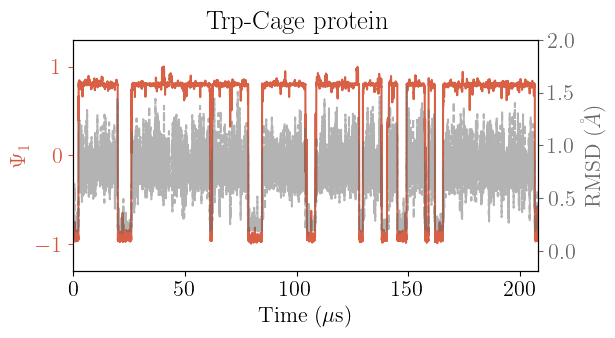

In [182]:
# usetex for matplotlib
import matplotlib
from matplotlib import rc
rc('text', usetex=True)

# define subplot with fontsize 12 
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(6, 3),sharex=True)

ev = 10

df_r[::ev].plot('time','TICA-1',ax=ax, color='fessa6',alpha=0.95,label=None,zorder=0)

ax.set_xlim(0,208)
ax.set_xlabel(r'Time ($\mu$s)')
ax.set_ylim(-1.3,1.3)
ax.set_ylabel(r'$\Psi_1$')
#color label and axis with red
ax.yaxis.label.set_color('fessa6')
ax.tick_params(axis='y', colors='fessa6')
#remove legend
ax.legend().remove()

# twinx and plot rmsd
ax2 = ax.twinx()
df[::ev].plot('time','rmsd',linestyle='--',ax=ax2, color='dimgrey',label=None,alpha=0.5,zorder=-1)
ax2.set_ylabel(r'RMSD ($\AA$)')
ax2.set_ylim(-0.19,2)
#color label and axis with dimgrey
ax2.yaxis.label.set_color('dimgrey')
ax2.tick_params(axis='y', colors='dimgrey')
ax2.legend().remove()
plt.suptitle('Trp-Cage protein')
plt.savefig('analysis/trpcage/trpcage.svg',dpi=300,bbox_inches='tight')


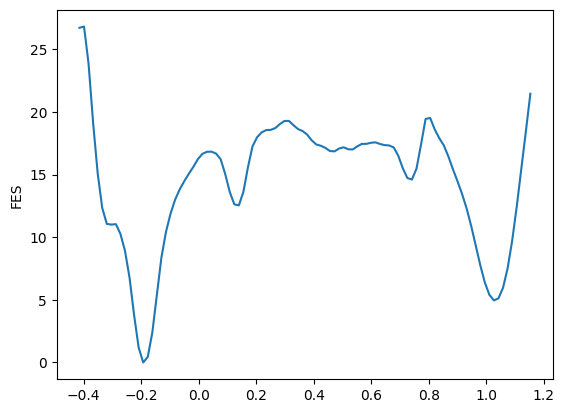

In [151]:
from mlcolvar.utils.fes import compute_fes
with torch.no_grad():
    s = df['TICA-1'].values
fes,grid,bounds,error = compute_fes(s,
    blocks=1,
    temp=290,
    bandwidth=0.01, scale_by='range',
    plot=True, plot_max_fes=200,eps=1e-14)

## LOAD AND COMPUTE EIGENFUNCTIONS

In [3]:
protein_id = "2JOF"
traj_id = 0
run_id = "8szjhk4u"

wandb_run = api.run(f'csml/encoderops-{protein_id}/{run_id}')

<Axes: xlabel='trainer/global_step'>

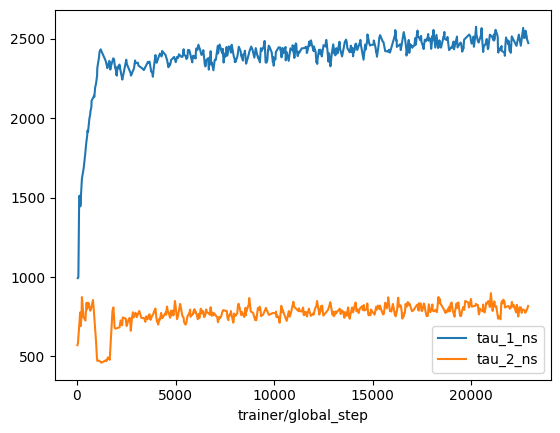

In [4]:
fig, ax = plt.subplots()
# plot from wandb history
wandb_run.history().plot("trainer/global_step", "tau_1_ns",ax=ax)
wandb_run.history().plot("trainer/global_step", "tau_2_ns",ax=ax)

In [5]:
subsample = 10

model, results = load_run(run_id, protein_id, subsample=subsample)

2025-05-15 15:37:36.234 | INFO     | __main__:load_run:69 - Subsampling every 10 samples (104300)


1043000


  0%|          | 0/102 [00:00<?, ?it/s]

2025-05-15 15:41:29.922 | INFO     | __main__:load_run:103 - model mean tensor([0.2459, 0.2696, 0.2413, 0.2432, 0.2479, 0.2484, 0.2404, 0.2633, 0.2530,
        0.2473, 0.2486, 0.2511, 0.2062, 0.3111, 0.2598, 0.2229, 0.2267, 0.2702,
        0.2288, 0.2743, 0.2699, 0.2416, 0.2484, 0.2401, 0.2408, 0.2466, 0.2474,
        0.2652, 0.2339, 0.2478, 0.2505, 0.2678, 0.2585, 0.2507, 0.2397, 0.2511,
        0.2479, 0.2476, 0.2500, 0.2545, 0.2316, 0.2386, 0.2810, 0.2488, 0.2395,
        0.2520, 0.2505, 0.2580, 0.2391, 0.2433, 0.2484, 0.2692, 0.2379, 0.2736,
        0.2433, 0.2452, 0.2315, 0.2939, 0.2560, 0.2187, 0.2467, 0.2493, 0.2426,
        0.2614], device='cuda:0')
stat mean tensor([0.2447, 0.2703, 0.2396, 0.2454, 0.2495, 0.2482, 0.2416, 0.2608, 0.2508,
        0.2528, 0.2424, 0.2540, 0.2080, 0.3098, 0.2575, 0.2247, 0.2273, 0.2708,
        0.2301, 0.2718, 0.2679, 0.2399, 0.2537, 0.2385, 0.2419, 0.2490, 0.2487,
        0.2604, 0.2366, 0.2500, 0.2519, 0.2615, 0.2568, 0.2442, 0.2434, 0.2556,
    

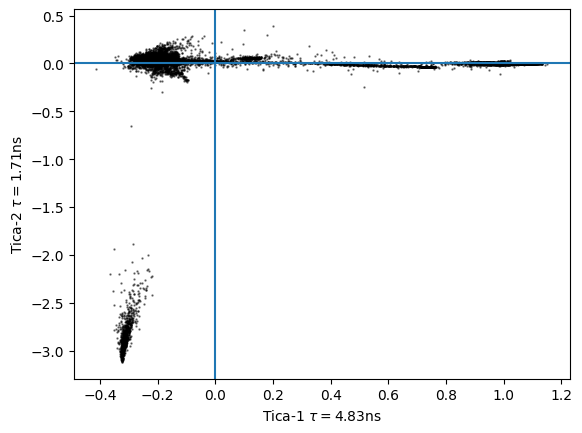

In [6]:
r_fun = results['r_fun'].real
def implied_timescale(ev, lagtime_ns: float = 0.2):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    timescale = -1*(lagtime_ns / np.log(np.abs(ev)))
    return np.sort(timescale)[::-1]

idxs = (0, 1)
plt.scatter(r_fun[:, idxs[0]].real, r_fun[:, idxs[1]].real, color='k', s = 0.5, alpha=0.5)
taus = implied_timescale(results['eigenvalues'])
plt.xlabel(f'Tica-{idxs[0] + 1} $\\tau=${taus[idxs[0]]:.2f}ns')
plt.ylabel(f'Tica-{idxs[1] + 1} $\\tau=${taus[idxs[1]]:.2f}ns')
plt.axhline(0)
plt.axvline(0)

Text(0, 0.5, 'Distribution')

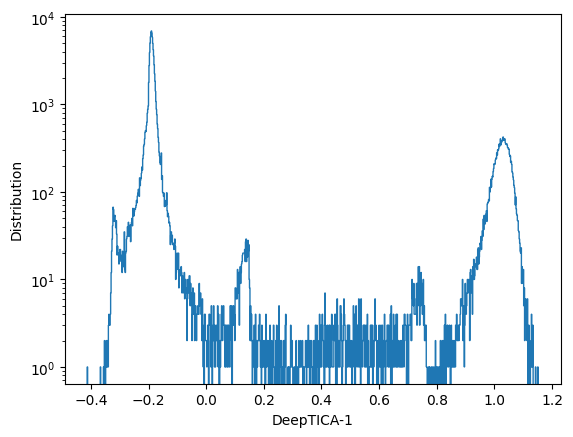

In [7]:
fig, ax = plt.subplots()
eigfun_idx = 0
mask = results['r_fun'][:, 0].real > -1
eigfun = results['r_fun'][:, eigfun_idx].real
ax.hist(eigfun,bins=1000,histtype='step')
ax.set_yscale('log')
ax.set_xlabel(f'DeepTICA-{eigfun_idx + 1}')
ax.set_ylabel('Distribution')

fig, ax = plt.subplots()
eigfun_idx = 1
mask = results['r_fun'][:, 0].real < 0 
eigfun = results['r_fun'][:, eigfun_idx].real
ax.hist(eigfun,bins=1000,histtype='step')
ax.set_yscale('log')
ax.set_xlabel(f'DeepTICA-{eigfun_idx + 1}')
ax.set_ylabel('Distribution')

## COLVAR (compute)

In [8]:
import os
from pathlib import Path
import mdtraj as md
import pandas as pd

def colvars(
    protein_id: str,
    sample_idxs: list[int] | None,
    traj_id: int = 0,
    contact_cutoff: float = 0.5,  # in nanometers
    ref_file: str | None = None   # path to reference PDB or DCD file
):
    protein_path = Path(os.environ["DATA_PATH"]) / f"DESRES-Trajectory_{protein_id}-{traj_id}-protein/{protein_id}-{traj_id}-protein"
    trajectory_files = sorted([str(traj) for traj in protein_path.glob("*.dcd")])
    print(trajectory_files)
    top = next(protein_path.glob("*.pdb")).__str__()

    traj = md.load(trajectory_files, top=top)
    print(len(traj))
    if sample_idxs:
        traj = traj[sample_idxs]

    # Load reference structure
    if ref_file is not None:
        ref = md.load(ref_file, top=top)[0]
    else:
        ref = traj[0]

    # Radius of gyration
    rg = md.compute_rg(traj)

    # Number of hydrogen bonds
    hbonds_per_frame = md.wernet_nilsson(traj)
    n_hbonds = [len(hb) for hb in hbonds_per_frame]

    # RMSD to reference
    rmsd = md.rmsd(traj, ref)

    # Fraction of native contacts (Q) using CA–CA contacts
    atom_pairs = md.compute_contacts(ref, contacts='all', scheme='ca')[1]
    native_distances = md.compute_distances(ref, atom_pairs)
    native_contacts_mask = native_distances[0] < contact_cutoff
    native_contacts = atom_pairs[native_contacts_mask]

    current_distances = md.compute_distances(traj, native_contacts)
    Q = (current_distances < contact_cutoff).sum(axis=1) / len(native_contacts)

    # Assemble DataFrame
    colvars_df = pd.DataFrame({
        "radius_of_gyration": rg,
        "num_hbonds": n_hbonds,
        "rmsd": rmsd,
        "Q": Q
    })

    feats_info = {}

    return traj, colvars_df, feats_info


In [9]:
traj, colvar, feats_info = colvars(protein_id, sample_idxs=results['sample_idxs'], ref_file = "/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein.pdb" ) 
#ref_file= "/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/ref.pdb") #"/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein.pdb")#, descriptors=['hbonds_distances'])


['/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-000.dcd', '/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-001.dcd', '/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-002.dcd', '/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-003.dcd', '/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-004.dcd', '/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-005.dcd', '/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-006.dcd', '/home/lbonati@iit.local/work/encoderops/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-007.dcd', '/home/lbonati@iit.local/work/e

In [10]:
idxs = (0, 1)
colvar[f'TICA-{idxs[0]+1}'] = r_fun[:, idxs[0]].real
colvar[f'TICA-{idxs[1]+1}'] = r_fun[:, idxs[1]].real

In [15]:
colvar.to_csv("analysis/trpcage/COLVAR_WITH_TICA.csv")

<Axes: xlabel='rmsd', ylabel='radius_of_gyration'>

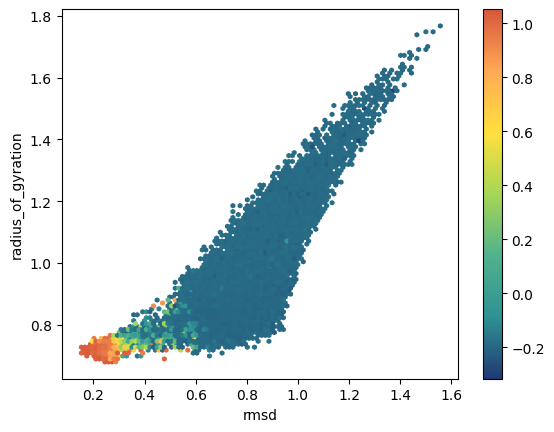

In [146]:
colvar.plot(x="rmsd", y="radius_of_gyration", C="TICA-1", kind="hexbin",cmap='fessa')

<Axes: xlabel='TICA-1', ylabel='rmsd'>

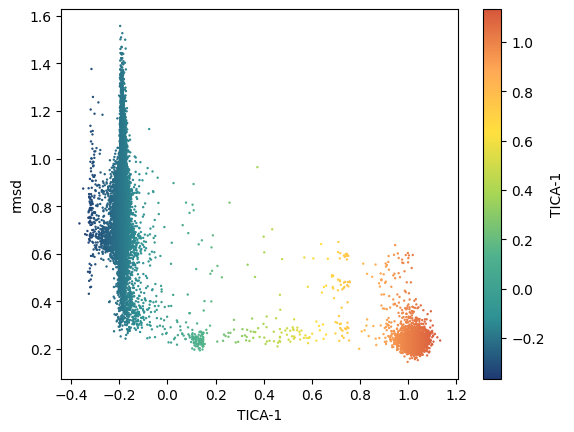

In [147]:
colvar.plot(x="TICA-1", y="rmsd", c='TICA-1', kind="scatter",cmap='fessa',s=0.5)

Text(0, 0.5, 'Tica-2 $\\tau=$1.71ns')

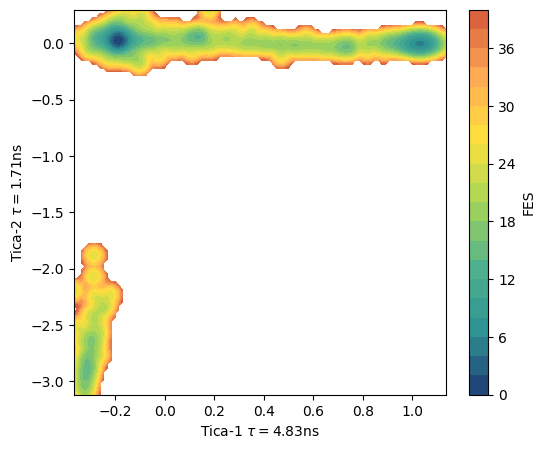

In [159]:
from mlcolvar.utils.fes import compute_fes
fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)
max_fes = 40
# compute cvs
with torch.no_grad():
    s = torch.stack([r_fun[:, idx].real for idx in idxs]).T
    
fes,grid,bounds,error = compute_fes(s,
    blocks=1,
    bandwidth=0.01, scale_by='range',
    plot=False, plot_max_fes=200, ax = ax, eps=1e-10)

fes2 = fes.copy()
if max_fes is not None:
    fes2[fes2 > max_fes] = np.nan
extent = [item for sublist in bounds for item in sublist]
pp = ax.contourf(fes2, levels=20, cmap="fessa", extent=extent)  # ,vmax=max_fes)
cbar = plt.colorbar(pp, ax=ax)
cbar.set_label("FES")
# ax.set_xlim(-3, 2)
# ax.set_ylim(-3, 2)
plt.xlabel(f'Tica-{idxs[0] + 1} $\\tau=${taus[idxs[0]]:.2f}ns')
plt.ylabel(f'Tica-{idxs[1] + 1} $\\tau=${taus[idxs[1]]:.2f}ns')

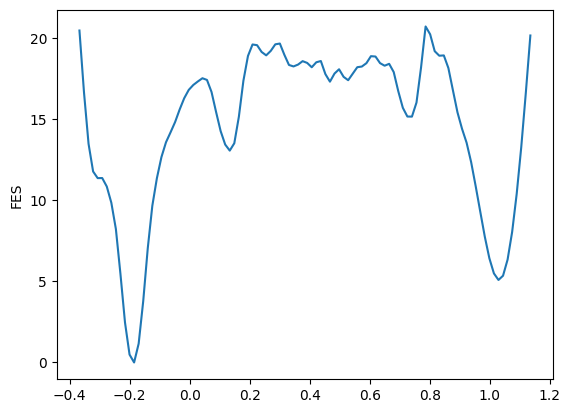

In [157]:
with torch.no_grad():
    s = r_fun[:, 0].real
fes,grid,bounds,error = compute_fes(s,
    blocks=1,
    bandwidth=0.01, scale_by='range',
    plot=True, plot_max_fes=200,eps=1e-10)

## LASSO CLASSIFICATION

In [87]:
traj, desc_df, feats_info = descriptors(protein_id, sample_idxs=results['sample_idxs'], descriptors=['hbonds_contacts'])

/home/lbonati@iit.local/work/encoderops/analysis/descriptors.py:318: RuntimeWarning: invalid value encountered in divide
  _y = (1.0 - np.power(y, n)) / (1.0 - np.power(y, m))


In [90]:
from mlcolvar.data import DictDataset
df = desc_df.copy()

# TICA 1
eigfun_idx = 0
eigfun = results['r_fun'][:, eigfun_idx].real
mask = results['r_fun'][:, 0].real > -1
labels = np.zeros(len(df))
# State 1
labels[np.argwhere(np.logical_and(eigfun < 0, mask))] = 1
# State 2
labels[np.argwhere(np.logical_and(eigfun > 0, mask))] = 2

# # TICA 2
# eigfun_idx = 1
# eigfun = results['r_fun'][:, eigfun_idx].real
# mask = results['r_fun'][:, 0].real < 0
# labels = np.zeros(len(df))
# # State 1
# labels[np.argwhere(np.logical_and(eigfun < -0.5, mask))] = 1
# # State 2
# labels[np.argwhere(np.logical_and(eigfun > -0.5, mask))] = 2

df['labels'] = labels
sel = (df['labels'] != 0 )

descr_type = 'distances' #'angles' #'distances' #'angles' 
stride = 20

if descr_type == 'angles':
    # get descriptors
    X = df[sel].filter(regex='phi|psi|xi|theta').values[::stride]
    feat_names = df[sel].filter(regex='phi|psi|xi|theta').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

elif descr_type == 'distances':
    # get descriptors
    X = df[sel].filter(regex='HB').values[::stride]
    feat_names = df[sel].filter(regex='HB').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

# create dataset
dataset = DictDataset(dict(data=X,labels=y))
dataset.feature_names = feat_names
dataset

DictDataset( "data": [1043, 717], "labels": [1043], "data_type": descriptors )

In [79]:
from mlcolvar.explain.lasso import SparsityScoring, lasso_classification, plot_lasso_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel
def lasso_classification(dataset,
                         min_features = 0,
                         Cs = 40,
                         scale_inputs = True,
                         feature_names = None,
                         print_info = True,
                         plot = True
):
    """Perform sparse classification via LASSO on a given DictDataset (requires keys: "data" and "labels").
    The (inverse) regularization strength C is automatically chosen based on cross-validation on a set of values (Cs),
    see sklearn.linear_model.LogisticRegressionCV. The scoring function used is `SparsityScoring`, balancing the accuracy and the number of features.

    In the two-classes case a single classifier is built, otherwise a one-vs-rest classifier is constructed, composed by N different estimators are trained to classify each state from the others.
    
    Parameters
    ----------
    dataset : DictDataset
        dataset with 'data' and 'labels'
    min_features : int, optional
        minimum number of features, by default 0
    Cs : int or array-like, optional
        Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization., by default 40
    scale_inputs : bool, optional
        whether to standardize inputs based on mean and std.dev., by default True
    feature_names : list, optional
        names of the input features, if not given they are taken from `dataset.feature_names`, by default None
    print_info : bool, optional
        whether to print results, by default True
    plot : bool, optional
        whether to plot results, by default True

    See also
    --------
    mlcolvar.explain.lasso.SparsityScoring
        Scoring function used in LASSO classification

    Returns
    -------
    classifier: 
        optimized estimator
    feats: 
        dictionary with the names of the non-zero features, per label
    coeffs: 
        dictionary with the coefficients of the non-zero features, per label
    """

    # Convert dataset to numpy
    with torch.no_grad():
        raw_descriptors = dataset['data'].numpy()
        labels = dataset['labels'].numpy().astype(int)
    if feature_names is None:
        if dataset.feature_names is None:
            raise ValueError('Feature names not found (either in the dataset or as argument to the function).')
        feature_names = dataset.feature_names
    
    # Scaling inputs
    if scale_inputs:
        scaler = StandardScaler(with_mean=True, with_std=True)
        descriptors = scaler.fit_transform(raw_descriptors)
    else:
        descriptors = raw_descriptors

    # Define cross-validation for LASSO, using
    #   a custom scoring function based on accuracy and number of features
    scorer = SparsityScoring(min_features=min_features) 

    _classifier = LogisticRegressionCV(Cs=Cs, 
                                    solver='liblinear', 
                                    multi_class='ovr', 
                                    fit_intercept=False, 
                                    penalty='l1',
                                    n_jobs=20, 
                                    max_iter = 200,
                                    scoring=scorer)

    # Fit classifier
    feature_selector = SelectFromModel(_classifier)
    feature_selector.fit(descriptors, labels)

    classifier = feature_selector.estimator_

    # Get selected features and coefficients 
    feats = {}
    coeffs = {}

    for i,key in enumerate(classifier.coefs_paths_.keys()):

        index = np.abs(classifier.coef_).argsort()[i][::-1]

        sorted_feature_names = feature_names[index]
        sorted_coeffs = classifier.coef_[i,index]

        idx = np.argwhere ( np.abs(sorted_coeffs)>1e-5 )[:,0]
        selected_feature_names = sorted_feature_names[idx]
        selected_coeffs = sorted_coeffs[idx] 
        feats[key] = selected_feature_names
        coeffs[key] = selected_coeffs

        # display summary
        if print_info:
            #score = classifier.score(descriptors,labels)
            C_idx = np.argwhere(np.abs(classifier.Cs_ - classifier.C_[i]) < 1e-8)[0,0]
            score = classifier.scores_[key].mean(axis=0)[C_idx]
            accuracy = classifier.scoring.accuracy_from_score(score, len(selected_coeffs))

            print(f'======= LASSO results ({key}) ========')
            print(f'- Regularization : {classifier.C_[i]:.8f}')
            print(f'- Score          : {score:.2f}')
            print(f'- Accuracy       : {accuracy*100:.2f}%')
            print(f'- # features     : {len(selected_coeffs)}\n')
            print('Features: ')
            for j,(f,c) in enumerate(zip(selected_feature_names, selected_coeffs)):
                print(f'({j+1}) {f:13s}: {c:.6f}')
            print('==================================\n')

    # plot results
    if plot:
        plot_lasso_classification(classifier, feats, coeffs)

    return classifier, feats, coeffs

/home/lbonati@iit.local/work/encoderops/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


======= LASSO results (2) ========
- Regularization : 0.00429193
- Score          : -7.88
- Accuracy       : 96.12%
- # features     : 4

Features: 
(1) HB_C GLY10-O -- SER13-N: 0.283973
(2) HB_C TRP6-NE1s -- ARG16-O: 0.158999
(3) HB_C TRP6-O -- GLY11-N: 0.110452
(4) HB_C GLY11-O -- ARG16-N: 0.055512



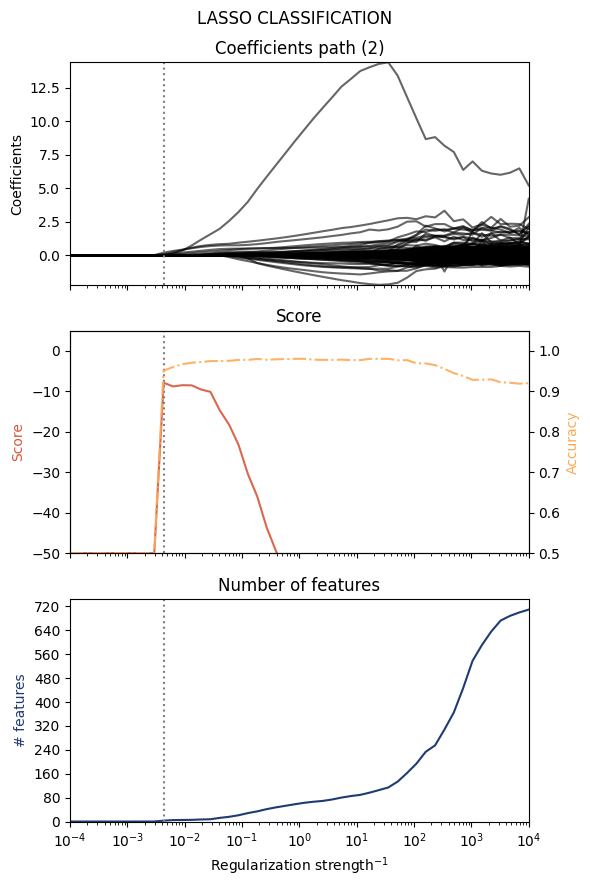

In [91]:
classifier, feats, coeffs = lasso_classification(dataset, Cs=50, plot=True)

/tmp/ipykernel_2537850/3380253061.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


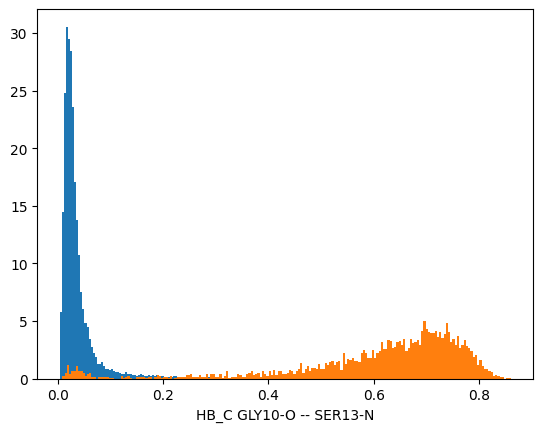

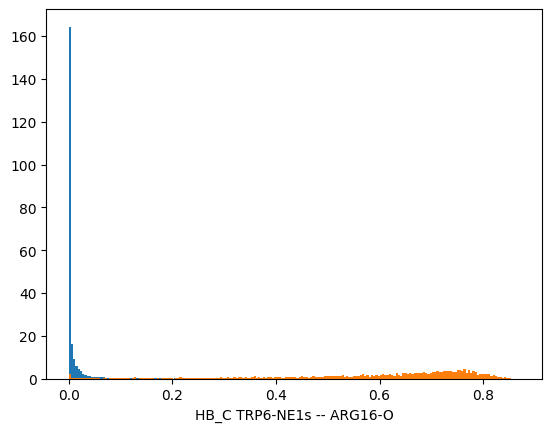

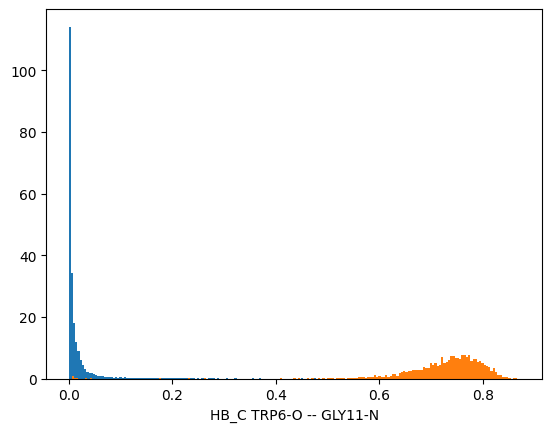

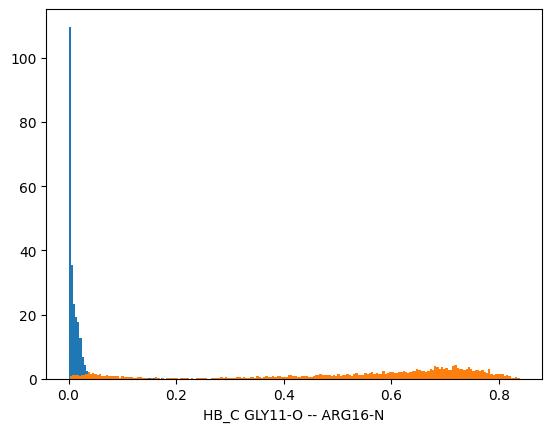

In [93]:
#fig, ax = plt.subplots(len)
for k, feat in feats.items():
    colors = ['r', 'b']
    for f in feat:
        plt.figure()
        plt.xlabel(f)
        for lab_id, label in enumerate([1, 2]):
            mask = labels == label
            x = desc_df[f].values[mask]
            plt.hist(x, bins=200,density=True)
    #ax.set_xlabel(feat[0])
fig.legend()

In [14]:
traj_1 = traj[::10][labels[::10] == 1]
traj_2 = traj[::10][labels[::10] == 2]

traj_1.save_pdb(f"{protein_id}_eig1_unfolded2.pdb")
traj_2.save_pdb(f"{protein_id}_eig1_folded2.pdb")

## LASSO REGRESSION

In [24]:
traj, desc_df, feats_info = descriptors(protein_id, sample_idxs=results['sample_idxs'], descriptors=['hbonds_distances'])

Text(0, 0.5, 'Distribution')

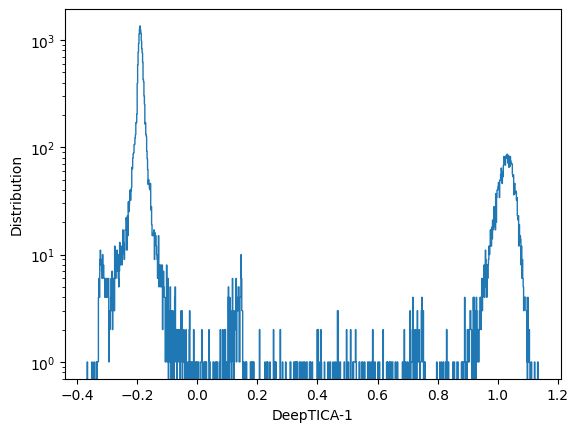

In [94]:
fig, ax = plt.subplots()
eigfun_idx = 0
mask = ( results['r_fun'][:, 0].real > -1 )
#mask = ( results['r_fun'][:, 0].real > 0 ) & ( results['r_fun'][:, 0].real < 0.8 )
#mask = ( results['r_fun'][:, 0].real < 0 ) #| ( results['r_fun'][:, 0].real > 0.8 )
eigfun = results['r_fun'][:, eigfun_idx].real
ax.hist(eigfun[mask],bins=1000,histtype='step')
ax.set_yscale('log')
ax.set_xlabel(f'DeepTICA-{eigfun_idx + 1}')
ax.set_ylabel('Distribution')

/tmp/ipykernel_2537850/1552515520.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['target'] = torch.tensor(r_fun[:, eigfun_idx].real)[mask]


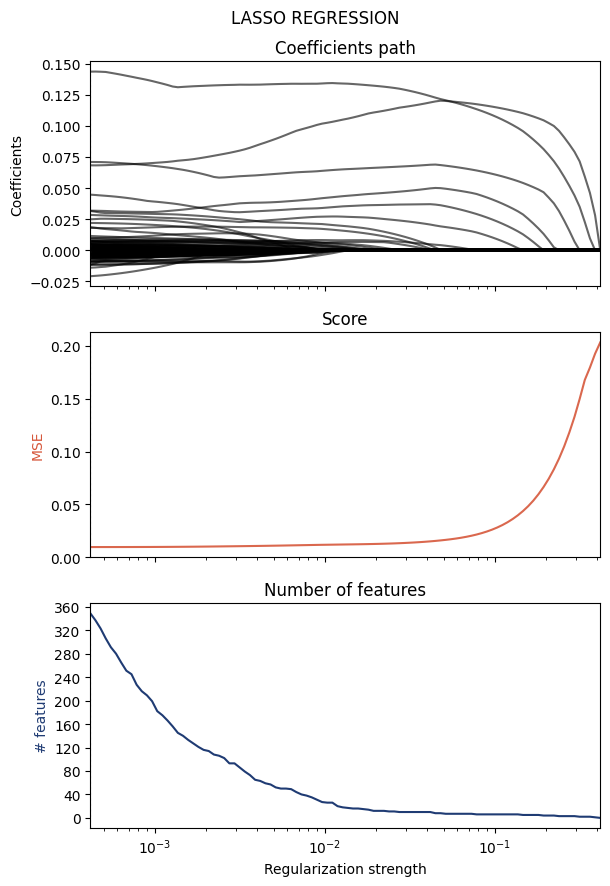

In [123]:
from mlcolvar.data import DictDataset

dataset = DictDataset(
    dictionary={
    'data': desc_df.values[mask,:]
},
    feature_names=desc_df.columns.tolist(),  # ensure it's a list of strings
)

dataset['target'] = torch.tensor(r_fun[:, eigfun_idx].real)[mask]

from mlcolvar.explain.lasso import lasso_regression

regressor, feats, coeffs = lasso_regression(dataset, alphas=None, plot=True, print_info=False)

In [125]:
# we analyze the coefficient paths of the cross-validated model to find the alphas which correpond to different number of features
num_features_path_ = np.count_nonzero(regressor.coefs_paths_.T, axis = 1)

selected_alphas = {}
for num_feat in np.unique(num_features_path_):
    if num_feat == 0:
        continue

    id = np.argwhere(num_features_path_ == num_feat).min()
    alpha = regressor.alphas_[id]
    
    selected_alphas[num_feat] = alpha
    print(f'num_feat={num_feat} --> alpha={alpha:.2e} (score={regressor.mse_path_[id].mean()})')

num_feat=1 --> alpha=3.88e-01 (score=0.19267582893371582)
num_feat=2 --> alpha=3.62e-01 (score=0.17957209050655365)
num_feat=3 --> alpha=2.94e-01 (score=0.1328425258398056)
num_feat=4 --> alpha=2.22e-01 (score=0.08318060636520386)
num_feat=5 --> alpha=1.80e-01 (score=0.059549588710069656)
num_feat=6 --> alpha=1.36e-01 (score=0.0396302156150341)
num_feat=7 --> alpha=7.28e-02 (score=0.0202786885201931)
num_feat=8 --> alpha=4.79e-02 (score=0.0158506128937006)
num_feat=10 --> alpha=4.16e-02 (score=0.014951582066714764)
num_feat=11 --> alpha=2.56e-02 (score=0.013026585802435875)
num_feat=12 --> alpha=2.22e-02 (score=0.012716691009700298)
num_feat=14 --> alpha=1.80e-02 (score=0.012370388023555279)
num_feat=15 --> alpha=1.68e-02 (score=0.012279074639081955)
num_feat=16 --> alpha=1.57e-02 (score=0.012194229289889336)
num_feat=17 --> alpha=1.36e-02 (score=0.012045035138726234)
num_feat=18 --> alpha=1.27e-02 (score=0.011973273940384388)
num_feat=20 --> alpha=1.19e-02 (score=0.011899208649992943)

y=+0.2888*HB_C GLY11-O -- ARG16-N +0.2769*HB_C GLY10-O -- SER13-N +0.1602*HB_C TRP6-O -- GLY11-N +0.1160*HB_C TRP6-NE1s -- ARG16-O +0.0862*HB_C GLN5-O -- ASP9-N +0.0481*HB_C TRP6-NE1s -- PRO17-O +0.0113*HB_C TRP6-NE1s -- PRO18-N +0.0091*HB_C GLY11-O -- SER14-OGs +0.0029*HB_C TRP6-NE1s -- GLY11-O +0.0004*HB_C ALA2-O -- TRP6-N


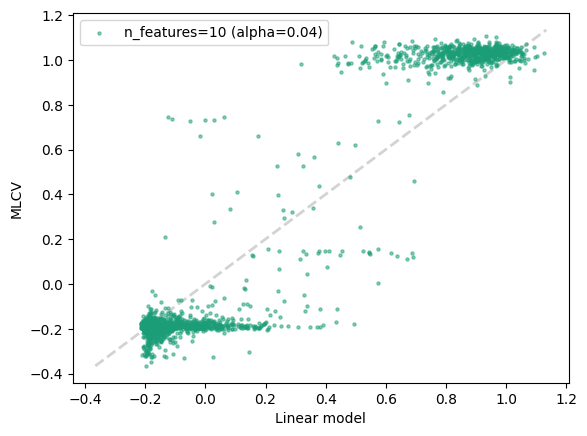

In [166]:
alphas = [10]

# standardize inputs
with torch.no_grad():
    X = dataset['data'].numpy()
    y = dataset['target'].numpy()

from sklearn.preprocessing import StandardScaler
X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# test different values of alpha
from cycler import cycler
fig,ax = plt.subplots()
ax.set_prop_cycle(cycler(color=plt.get_cmap('Dark2').colors))

for alpha in alphas:
    if alpha not in selected_alphas:
        continue    
    else:
        alpha = selected_alphas[alpha]
    regressor, feats, coeffs = lasso_regression(dataset, alphas=[alpha],print_info=False,plot=False)
    y_pred = regressor.predict(X)
    ax.scatter(y_pred[::5], y[::5],s=5,label=f'n_features={len(coeffs)} (alpha={alpha:.2f})',alpha=0.5)
    # print equation
    equation = "y="
    coeffs = coeffs / coeffs.sum()
    for f, c in zip(feats,coeffs):
        equation+=f"+{c:.4f}*{f} " if c> 0 else f"{c:.3f}*{f} "

    print(equation[:-1])
    

ax.set_xlabel('Linear model')
ax.set_ylabel('MLCV')
ax.plot([y.min(),y.max()],[y.min(),y.max()],linewidth=2,color='lightgrey',zorder=0,linestyle='dashed')
ax.legend(frameon=True)
plt.show()

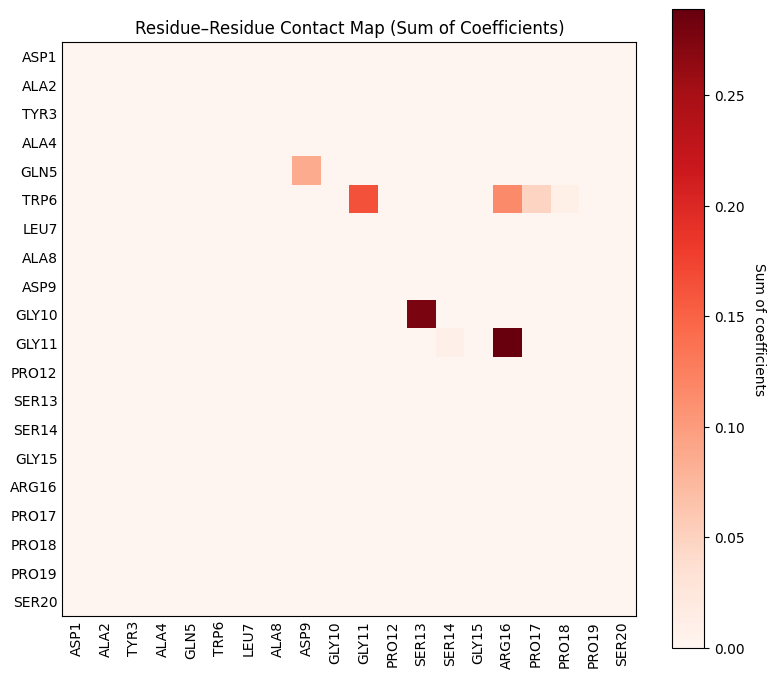

In [135]:
import re
# Step 1: Extract all unique residues
residues_unsorted = {r for v in feats_info.values() for r in v['group'].split('_')}

# Function to extract just the number from residue label
def extract_residue_number(res):
    match = re.search(r'(\d+)$', res)
    return int(match.group(1)) if match else -1

# Sort residues by numeric ID only
residues = sorted(residues_unsorted, key=extract_residue_number)
residue_indices = {res: i for i, res in enumerate(residues)}
N = len(residues)

# Step 2: Build residue-residue contact map
contact_map = np.zeros((N, N))

for feat, coeff in zip(feats, coeffs):
    group = feats_info[feat]['group']
    res1, res2 = group.split('_')
    i, j = residue_indices[res1], residue_indices[res2]
    contact_map[i, j] += np.abs(coeff)
    #contact_map[j, i] += np.abs(coeff)  # Symmetric

contact_map /= contact_map.sum()

# Step 3: Plot with matplotlib
fig, ax = plt.subplots(figsize=(8, 7))
cax = ax.imshow(contact_map, cmap='Reds', interpolation='nearest')#, vmin=np.abs(coeffs).min(), vmax=np.abs(coeffs).max())

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label("Sum of coefficients", rotation=270, labelpad=15)

# Set ticks and labels
ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(residues, rotation=90)
ax.set_yticklabels(residues)

# Styling
ax.set_title("Residue–Residue Contact Map (Sum of Coefficients)")
ax.tick_params(axis='both', which='both', length=0)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()